VAR là mô hình mở rộng của AR (Autoregression) cho nhiều biến.
Mỗi biến phụ thuộc vào chính nó (lag) và các biến khác (lag).
Dùng để xem xét quan hệ động (dynamic interdependence) giữa nhiều chuỗi thời gian.
=> VAR giúp xem sentiment dự báo return (hoặc ngược lại) sau một số lag.
- Biến 1: log-return của close.
- Biến 2: label (đã convert từ sentiment score PhoBERT).
Kết quả: nếu hệ số 𝑎2 có ý nghĩa → sentiment dự báo giá.

Data shape: (425, 2)
        ret  label
1 -0.071973      1
2  0.066752      1
3  0.067479      1
4 -0.055337      1
5 -0.067762      1
=== VAR Baseline ===
Best lag (AIC): 2
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 26, Sep, 2025
Time:                     15:49:25
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -6.90611
Nobs:                     423.000    HQIC:                  -6.96399
Log likelihood:           290.457    FPE:                0.000910250
AIC:                     -7.00179    Det(Omega_mle):     0.000889107
--------------------------------------------------------------------
Results for equation ret
              coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------
const           -0.002691         0.001489           -1.807 

c:\Users\HELLO\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


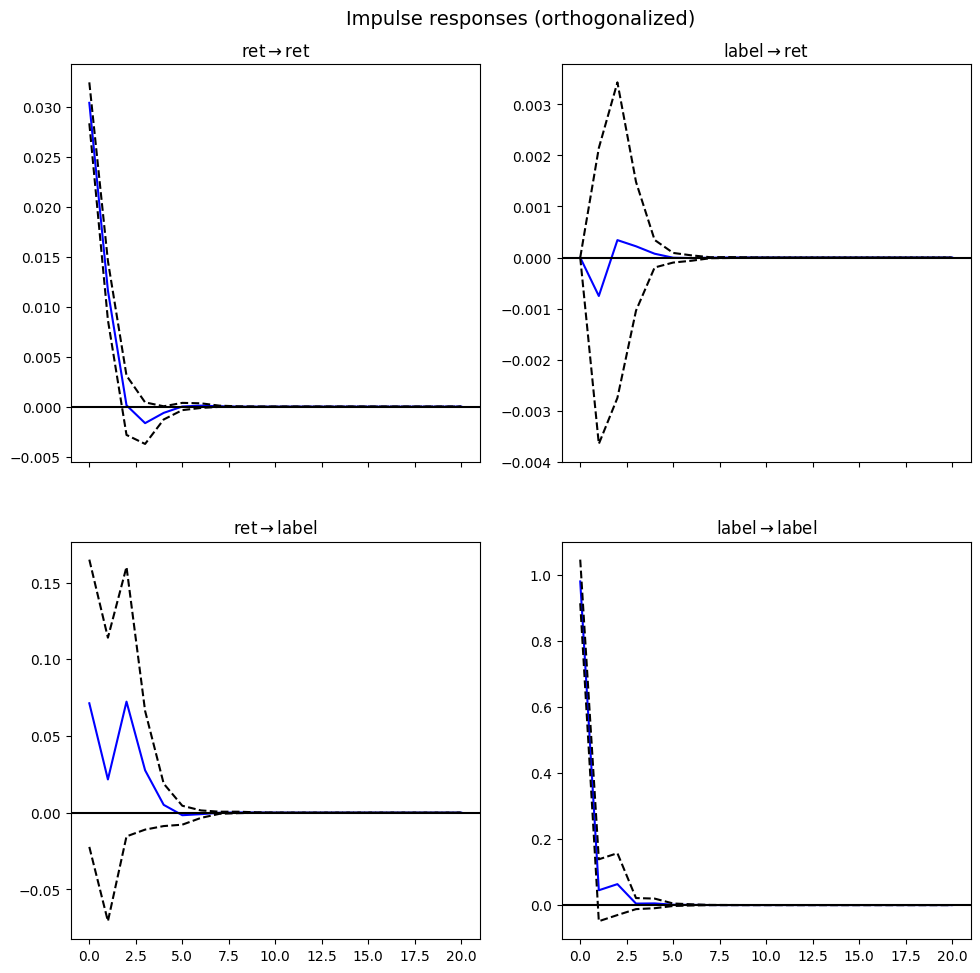

In [ ]:
import pandas as pd
import numpy as np
from statsmodels.tsa.api import VAR
import matplotlib.pyplot as plt

# 1. Load & chuẩn bị dữ liệu
df = pd.read_excel("AMD.xlsx")
df = df.sort_values("date")

# Convert close sang số & tính log-return
df["close"] = pd.to_numeric(df["close"], errors="coerce")
df["ret"] = np.log(df["close"].replace(0, np.nan)).diff()

# Làm sạch NaN/Inf
data = df[["ret","label"]].replace([np.inf, -np.inf], np.nan).dropna()

print("Data shape:", data.shape)
print(data.head())

# 2. VAR baseline
model = VAR(data)
sel = model.select_order(10)  # chọn độ trễ tối đa = 10
p = sel.selected_orders["aic"] # chọn lag theo AIC
res = model.fit(p)

print("=== VAR Baseline ===")
print("Best lag (AIC):", p)
print(res.summary())

# Vẽ IRF (Impulse Response Function) 20 bước
irf = res.irf(20)
irf.plot(orth=True)
plt.show()




Kết quả chính
- L1.ret (hệ số dương, p < 0.001) → return có động lượng ngắn hạn.

- L2.ret (hệ số âm, p = 0.003) → có tính đảo chiều sau 2 ngày.

- label (sentiment discrete) ở cả lag 1 và lag 2 không có ý nghĩa thống kê → sentiment theo dạng label rời rạc chưa giải thích được biến động giá.

- Ma trận tương quan phần dư (ret và label) ~ 0.07, rất thấp.

=> Kết luận: linear VAR cho thấy quan hệ yếu giữa sentiment (label) và return.

Threshold VAR (TVAR) → kiểm tra quan hệ phi tuyến: sentiment cực đoan tác động khác so với sentiment bình thường.
Khái niệm
- VAR giả định quan hệ tuyến tính cố định.
- TVAR cho phép tồn tại hai (hoặc nhiều) chế độ khác nhau, tùy theo một “threshold variable”.
=> Ở data này, threshold có thể đặt theo:
- label (VD: label = 1 = tích cực -> high regime, còn lại = low regime) -> tuy nhiên kết quả khó ra ý nghĩa mạnh do thông tin label thô
- continuous score (Tích cực - Tiêu cực) > quantile 80% = high sentiment regime -> dễ chứng minh phi tuyến (high vs low sentiment khác nhau rõ) -> nên dùng continuous score để chạy TVAR

THRESHOLD VAR VỚI BIẾN LABEL RỜI RẠC 
- Regime Low = ngày mà sentiment ≤ 0 (tiêu cực hoặc trung tính).
- Regime High = ngày mà sentiment > 0 (tích cực).

Obs Low: 219 Obs High: 205

=== TVAR Results ===
Low regime (label <= 0.00), lag=2
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 26, Sep, 2025
Time:                     15:50:31
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -6.84988
Nobs:                     217.000    HQIC:                  -6.94272
Log likelihood:           154.292    FPE:                0.000906769
AIC:                     -7.00564    Det(Omega_mle):     0.000866384
--------------------------------------------------------------------
Results for equation ret
              coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------
const           -0.002204         0.002053           -1.074           0.283
L1.ret           0.044039         0.066561            0.662           0.508

c:\Users\HELLO\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\HELLO\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


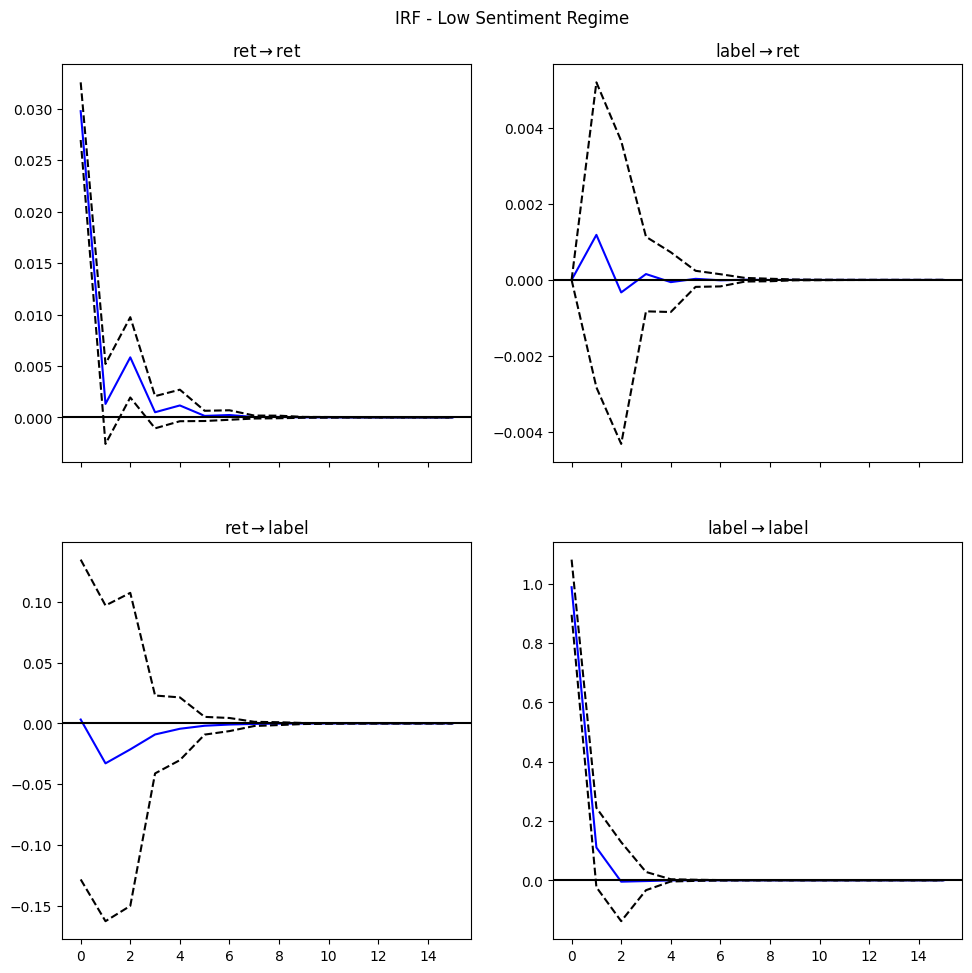

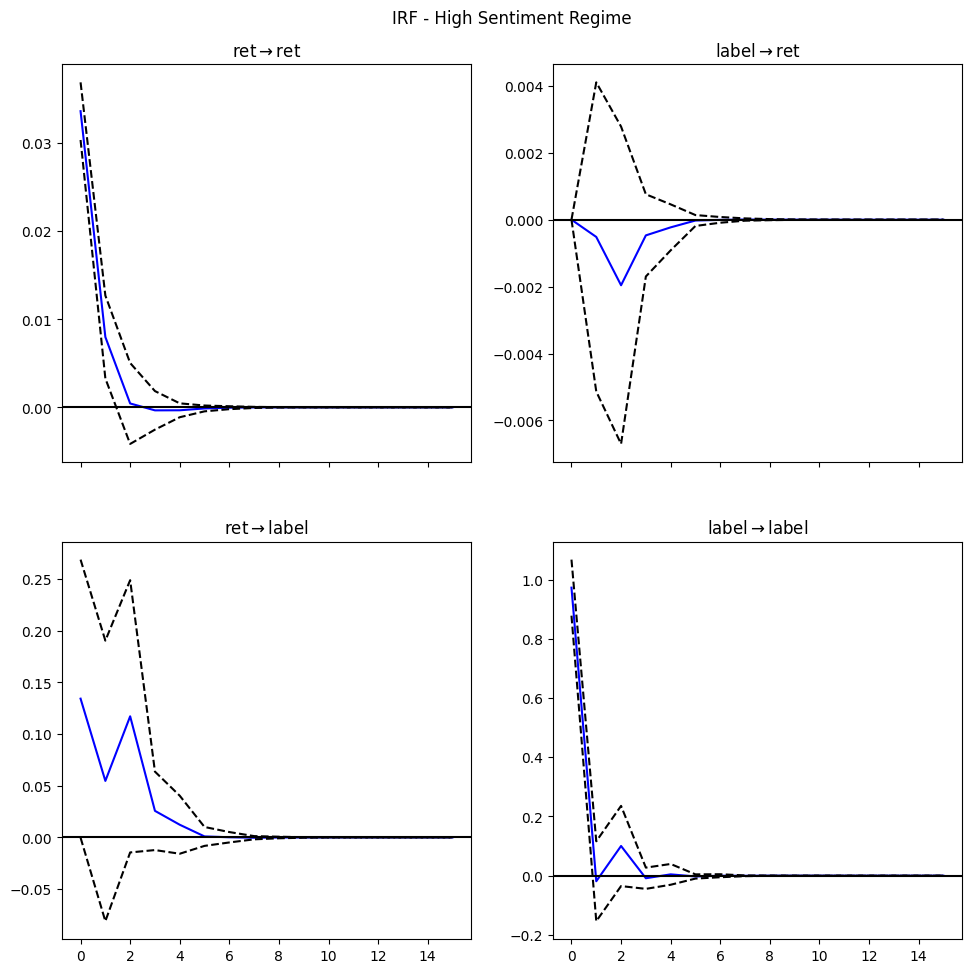

In [ ]:
# 3. Threshold VAR (TVAR) 
# Threshold: median thay vì quantile 80%
threshold = data['label'].median()

regime_low  = data[data['label'].shift(1) <= threshold].dropna()
regime_high = data[data['label'].shift(1) >  threshold].dropna()

print("Obs Low:", regime_low.shape[0], "Obs High:", regime_high.shape[0])

# VAR cho low regime
model_low = VAR(regime_low)
p_low = min(2, regime_low.shape[0]//5)  # lag nhỏ để tránh lỗi
res_low = model_low.fit(p_low)

# VAR cho high regime
model_high = VAR(regime_high)
p_high = min(2, regime_high.shape[0]//5)  # lag nhỏ để tránh lỗi
res_high = model_high.fit(p_high)

print("\n=== TVAR Results ===")
print("Low regime (label <= %.2f), lag=%d" % (threshold, p_low))
print(res_low.summary())
print("\nHigh regime (label > %.2f), lag=%d" % (threshold, p_high))
print(res_high.summary())

# IRF cho từng chế độ
irf_low = res_low.irf(15)
irf_high = res_high.irf(15)

# Low regime
fig = irf_low.plot(orth=True)
plt.suptitle("IRF - Low Sentiment Regime")
plt.show()

# High regime
fig = irf_high.plot(orth=True)
plt.suptitle("IRF - High Sentiment Regime")
plt.show()

KẾT QUẢ
- Low regime: sentiment gần như không liên quan return (residual correlation ≈ 0).
- High regime: residual correlation tăng (~0.14), return có động lượng mạnh.
→ Nghĩa là khi sentiment cao, giá phản ứng khác → đây là đặc điểm phi tuyến.


THRESHOLD VAR VỚI CONTINUOUS SCORE

Data shape: (425, 2)
        ret     score
1 -0.071973  0.045322
2  0.066752  0.303078
3  0.067479  0.226170
4 -0.055337  0.026100
5 -0.067762  0.067801
Obs Low: 213 Obs High: 211

=== TVAR Continuous Score Results ===
Low regime (score <= -0.00), lag=2
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 26, Sep, 2025
Time:                     16:27:32
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -10.4617
Nobs:                     211.000    HQIC:                  -10.5564
Log likelihood:           531.681    FPE:                2.44084e-05
AIC:                     -10.6206    Det(Omega_mle):     2.32915e-05
--------------------------------------------------------------------
Results for equation ret
              coefficient       std. error           t-stat            prob
--------------------------------------------------------

c:\Users\HELLO\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\HELLO\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


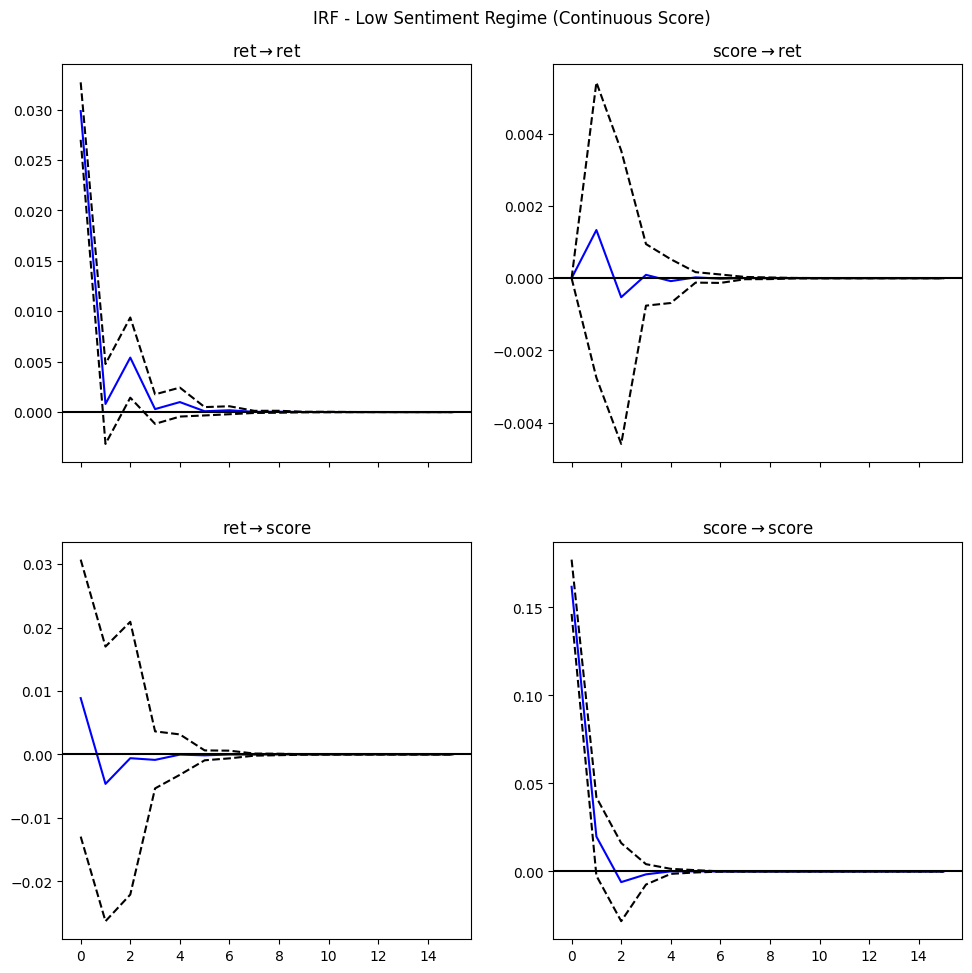

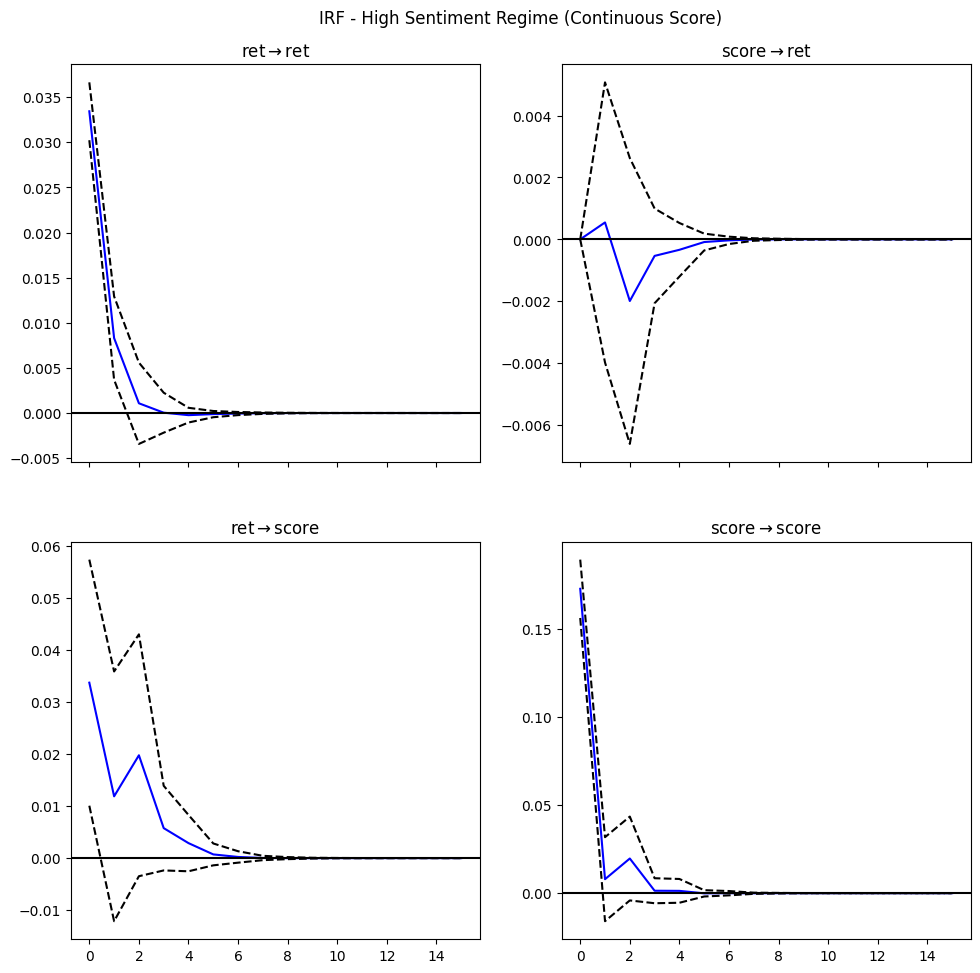

In [ ]:
import pandas as pd
import numpy as np
from statsmodels.tsa.api import VAR
import matplotlib.pyplot as plt

# 1. Load & chuẩn bị dữ liệu
df = pd.read_excel("AMD.xlsx")
df = df.sort_values("date")

# Tính log-return
df["close"] = pd.to_numeric(df["close"], errors="coerce")
df["ret"] = np.log(df["close"].replace(0, np.nan)).diff()

# Tạo sentiment continuous score = P(pos) - P(neg)
df["score"] = df["Tích cực"] - df["Tiêu cực"]

# Làm sạch NaN/Inf
data = df[["ret","score"]].replace([np.inf, -np.inf], np.nan).dropna()

print("Data shape:", data.shape)
print(data.head())

# 2. Threshold VAR (TVAR)
# Threshold = median score
threshold = data['score'].median()

regime_low  = data[data['score'].shift(1) <= threshold].dropna()
regime_high = data[data['score'].shift(1) >  threshold].dropna()

print("Obs Low:", regime_low.shape[0], "Obs High:", regime_high.shape[0])

# VAR cho low regime
model_low = VAR(regime_low)
p_low = min(2, regime_low.shape[0]//5)  # chọn lag nhỏ cho an toàn
res_low = model_low.fit(p_low)

# VAR cho high regime
model_high = VAR(regime_high)
p_high = min(2, regime_high.shape[0]//5)
res_high = model_high.fit(p_high)

print("\n=== TVAR Continuous Score Results ===")
print("Low regime (score <= %.2f), lag=%d" % (threshold, p_low))
print(res_low.summary())
print("\nHigh regime (score > %.2f), lag=%d" % (threshold, p_high))
print(res_high.summary())

# IRF cho từng chế độ
irf_low = res_low.irf(15)
irf_high = res_high.irf(15)

fig = irf_low.plot(orth=True)
plt.suptitle("IRF - Low Sentiment Regime (Continuous Score)")
plt.show()

fig = irf_high.plot(orth=True)
plt.suptitle("IRF - High Sentiment Regime (Continuous Score)")
plt.show()


KẾT QUẢ CỦA CONTINUOUS SCORE
1. Low regime (score ≤ 0)
- L2.ret = 0.183, p=0.007 → return hiện tại phụ thuộc dương vào return 2 ngày trước (tính đảo chiều yếu).
- Các hệ số score (sentiment) đều không ý nghĩa → sentiment không dự báo được giá trong giai đoạn này.
- Residual correlation = 0.05 → gần như độc lập.
=> khi sentiment thấp/trung tính, thị trường gần như không bị ảnh hưởng bởi tin tức.
2. High regime (score > 0)
- L1.ret = 0.245, p=0.001 → return có động lượng mạnh (giá hôm qua tăng → hôm nay có khả năng tăng tiếp).
- Các hệ số score không ý nghĩa thống kê → sentiment không dự báo trực tiếp, nhưng...
- Residual correlation = 0.19 (cao hơn nhiều so với 0.05 ở regime Low).
=> trong thời kỳ sentiment cao, biến động giá và sentiment đồng hành hơn, cho thấy tác động phi tuyến (nonlinear effect).